In [3]:
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.models.classification_models import EncDecFrameClassificationModel, EncDecClassificationModel
import numpy as np 
import librosa
import soundfile as sf 
import torch 
import inspect

fused_indices_to_multihot has reached end of life. Please migrate to a non-experimental function.
OneLogger: Setting error_handling_strategy to DISABLE_QUIETLY_AND_REPORT_METRIC_ERROR for rank (rank=0) with OneLogger disabled. To override: explicitly set error_handling_strategy parameter.
No exporters were provided. This means that no telemetry data will be collected.


In [4]:
import numpy as np
import pyaudio as pa
import os, time
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import nemo
import nemo.collections.asr as nemo_asr

In [5]:
inspect.signature(EncDecFrameClassificationModel.restore_from)

<Signature (restore_path: 'str', override_config_path: 'Optional[Union[OmegaConf, str]]' = None, map_location: 'Optional[torch.device]' = None, strict: 'bool' = True, return_config: 'bool' = False, save_restore_connector: 'SaveRestoreConnector' = None, trainer: 'Optional[Trainer]' = None, validate_access_integrity: 'bool' = True)>

In [6]:
vad_model = EncDecFrameClassificationModel.restore_from('models/vad_multilingual_marblenet.nemo', strict=False)
print("Load model successfull")

[NeMo W 2026-01-29 16:19:55 classification_models:641] Please use the EncDecSpeakerLabelModel instead of this model. EncDecClassificationModel model is kept for backward compatibility with older models.
[NeMo W 2026-01-29 16:19:55 modelPT:188] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_tr

[NeMo I 2026-01-29 16:19:55 features:306] PADDING: 16
[NeMo I 2026-01-29 16:19:55 save_restore_connector:284] Model EncDecClassificationModel was successfully restored from /home/minhth11/Projects/NeMo/models/vad_multilingual_marblenet.nemo.
Load model successfull


In [7]:
from omegaconf import OmegaConf
import copy
cfg = copy.deepcopy(vad_model._cfg)
print(OmegaConf.to_yaml(cfg))

sample_rate: 16000
repeat: 2
dropout: 0.0
kernel_size_factor: 1.0
n_filter: 64
labels:
- background
- speech
train_ds:
  manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
  sample_rate: 16000
  labels:
  - background
  - speech
  batch_size: 256
  shuffle: true
  is_tarred: false
  tarred_audio_filepaths: null
  tarred_shard_strategy: scatter
  augmentor:
    shift:
      prob: 0.5
      min_shift_ms: -10.0
      max_shift_ms: 10.0
    white_noise:
      prob: 0.5
  

In [8]:
vad_model.preprocessor = vad_model.from_config_dict(cfg.preprocessor)
vad_model.eval();
vad_model = vad_model.to(vad_model.device)

[NeMo I 2026-01-29 16:19:55 features:306] PADDING: 16


In [9]:
from nemo.core.classes import IterableDataset
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch
from torch.utils.data import DataLoader

In [10]:
class AudioDataLayer(IterableDataset):
    @property
    def output_types(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = signal.astype(np.float32)/32768.
        self.signal_shape = self.signal.size
        self.output = True

    def __len__(self):
        return 1

In [11]:
data_layer = AudioDataLayer(sample_rate=cfg.train_ds.sample_rate)
data_loader = DataLoader(data_layer, batch_size=1, collate_fn=data_layer.collate_fn)

In [12]:
def infer_signal(model, signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(vad_model.device), audio_signal_len.to(vad_model.device)
    logits = model.forward(input_signal=audio_signal, input_signal_length=audio_signal_len)
    return logits

In [13]:
class FrameVAD:
    
    def __init__(self, model_definition,
                 threshold=0.5,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          threshold: If prob of speech is larger than threshold, classify the segment to be speech.
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.threshold = threshold
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMFCCPreprocessor']['window_stride']
        for block in model_definition['JasperEncoder']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = infer_signal(vad_model, self.buffer).cpu().numpy()[0]
        decoded = self._greedy_decoder(
            self.threshold,
            logits,
            self.vocab
        )
        return decoded  
    
    
    @torch.no_grad()
    def transcribe(self, frame=None):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        return unmerged
    
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(threshold, logits, vocab):
        s = []
        if logits.shape[0]:
            probs = torch.softmax(torch.as_tensor(logits), dim=-1)
            probas, _ = torch.max(probs, dim=-1)
            probas_s = probs[1].item()
            preds = 1 if probas_s >= threshold else 0
            s = [preds, str(vocab[preds]), probs[0].item(), probs[1].item(), str(logits)]
        return s

In [14]:
STEP_LIST =        [0.01,0.01]
WINDOW_SIZE_LIST = [0.31,0.15]

In [15]:

import wave

def offline_inference(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5, threshold=0.5):
    
    FRAME_LEN = STEP # infer every STEP seconds 
    CHANNELS = 1 # number of audio channels (expect mono signal)
    RATE = 16000 # sample rate, Hz
    
   
    CHUNK_SIZE = int(FRAME_LEN*RATE)
    
    vad = FrameVAD(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor,
                   'JasperEncoder': cfg.encoder,
                   'labels': cfg.labels
               },
               threshold=threshold,
               frame_len=FRAME_LEN, frame_overlap = (WINDOW_SIZE-FRAME_LEN)/2,
               offset=0)

    wf = wave.open(wave_file, 'rb')
    p = pa.PyAudio()

    empty_counter = 0

    preds = []
    proba_b = []
    proba_s = []
    
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=CHANNELS,
                    rate=RATE,
                    output = True)

    data = wf.readframes(CHUNK_SIZE)

    while len(data) > 0:

        data = wf.readframes(CHUNK_SIZE)
        signal = np.frombuffer(data, dtype=np.int16)
        result = vad.transcribe(signal)

        preds.append(result[0])
        proba_b.append(result[2])
        proba_s.append(result[3])
        
        if len(result):
            print(result,end='\n')
            empty_counter = 3
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='')
                
    p.terminate()
    vad.reset()
    
    return preds, proba_b, proba_s
# import wave
# import numpy as np

# def offline_inference(wave_file, STEP=0.025, WINDOW_SIZE=0.5, threshold=0.5):

#     FRAME_LEN = STEP
#     CHANNELS = 1
#     RATE = 16000

#     CHUNK_SIZE = int(FRAME_LEN * RATE)

#     vad = FrameVAD(
#         model_definition={
#             'sample_rate': SAMPLE_RATE,
#             'AudioToMFCCPreprocessor': cfg.preprocessor,
#             'JasperEncoder': cfg.encoder,
#             'labels': cfg.labels
#         },
#         threshold=threshold,
#         frame_len=FRAME_LEN,
#         frame_overlap=(WINDOW_SIZE - FRAME_LEN) / 2,
#         offset=0
#     )

#     wf = wave.open(wave_file, 'rb')

#     preds = []
#     proba_b = []
#     proba_s = []

#     empty_counter = 0

#     while True:
#         data = wf.readframes(CHUNK_SIZE)
#         if not data:
#             break

#         signal = np.frombuffer(data, dtype=np.int16)
#         result = vad.transcribe(signal)

#         preds.append(result[0])
#         proba_b.append(result[2])
#         proba_s.append(result[3])

#         if len(result):
#             print(result)
#             empty_counter = 3
#         elif empty_counter > 0:
#             empty_counter -= 1
#             if empty_counter == 0:
#                 print(' ')

#     wf.close()
#     vad.reset()

#     return preds, proba_b, proba_s


In [16]:
import os
demo_wave = 'VAD_demo.wav'
if not os.path.exists(demo_wave):
    !wget "https://dldata-public.s3.us-east-2.amazonaws.com/VAD_demo.wav" 

In [17]:
wave_file = demo_wave

CHANNELS = 1
RATE = 16000
audio, sample_rate = librosa.load(wave_file, sr=RATE)
dur = librosa.get_duration(y=audio, sr=sample_rate)
print(dur)

2.9775


In [18]:
ipd.Audio(audio, rate=sample_rate)

In [19]:
threshold=0.4
SAMPLE_RATE=16000
results = []
for STEP, WINDOW_SIZE in zip(STEP_LIST, WINDOW_SIZE_LIST, ):
    print(f'====== STEP is {STEP}s, WINDOW_SIZE is {WINDOW_SIZE}s ====== ')
    preds, proba_b, proba_s = offline_inference(wave_file, STEP, WINDOW_SIZE, threshold)
    results.append([STEP, WINDOW_SIZE, preds, proba_b, proba_s])

====== STEP is 0.01s, WINDOW_SIZE is 0.31s ====== 


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No

[0, 'background', 0.9559160470962524, 0.044083889573812485, '[ 1.5382668 -1.5383089]']
[0, 'background', 0.8318525552749634, 0.16814745962619781, '[ 0.799388  -0.7994259]']
[0, 'background', 0.8249151110649109, 0.1750849187374115, '[ 0.77498573 -0.77502364]']
[0, 'background', 0.916843056678772, 0.08315688371658325, '[ 1.2000833 -1.200124 ]']
[0, 'background', 0.9744015336036682, 0.025598544627428055, '[ 1.8196218 -1.8196661]']
[0, 'background', 0.9913079142570496, 0.00869213417172432, '[ 2.368279  -2.3683274]']
[0, 'background', 0.9943893551826477, 0.005610664375126362, '[ 2.5887046 -2.588755 ]']
[0, 'background', 0.9945113658905029, 0.005488579161465168, '[ 2.5997658 -2.5998166]']
[0, 'background', 0.9949541687965393, 0.00504576088860631, '[ 2.6420486 -2.6420999]']
[0, 'background', 0.9964596629142761, 0.00354039017111063, '[ 2.8199592 -2.8200128]']
[0, 'background', 0.9972242116928101, 0.002775777829810977, '[ 2.9419947 -2.9420497]']
[0, 'background', 0.9973020553588867, 0.002697880

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No

[0, 'background', 0.9790247082710266, 0.020975254476070404, '[ 1.9215842 -1.9216294]']
[0, 'background', 0.9692565202713013, 0.030743420124053955, '[ 1.7254049 -1.7254485]']
[0, 'background', 0.8860859870910645, 0.11391405761241913, '[ 1.0256649 -1.0257049]']
[0, 'background', 0.89747554063797, 0.10252446681261063, '[ 1.084722  -1.0847623]']
[0, 'background', 0.9391109943389893, 0.06088898703455925, '[ 1.3679196 -1.3679616]']
[0, 'background', 0.9612091779708862, 0.03879082202911377, '[ 1.6049826 -1.6050258]']
[0, 'background', 0.9820607900619507, 0.017939172685146332, '[ 2.0013103 -2.0013564]']
[0, 'background', 0.9710078835487366, 0.028992146253585815, '[ 1.7556328 -1.755677 ]']
[0, 'background', 0.8314741253852844, 0.1685258150100708, '[ 0.7980361 -0.7980751]']
[1, 'speech', 0.579312801361084, 0.420687198638916, '[ 0.15995874 -0.15999429]']
[0, 'background', 0.7084448933601379, 0.29155510663986206, '[ 0.44390312 -0.44394013]']
[0, 'background', 0.8761956095695496, 0.1238044351339340

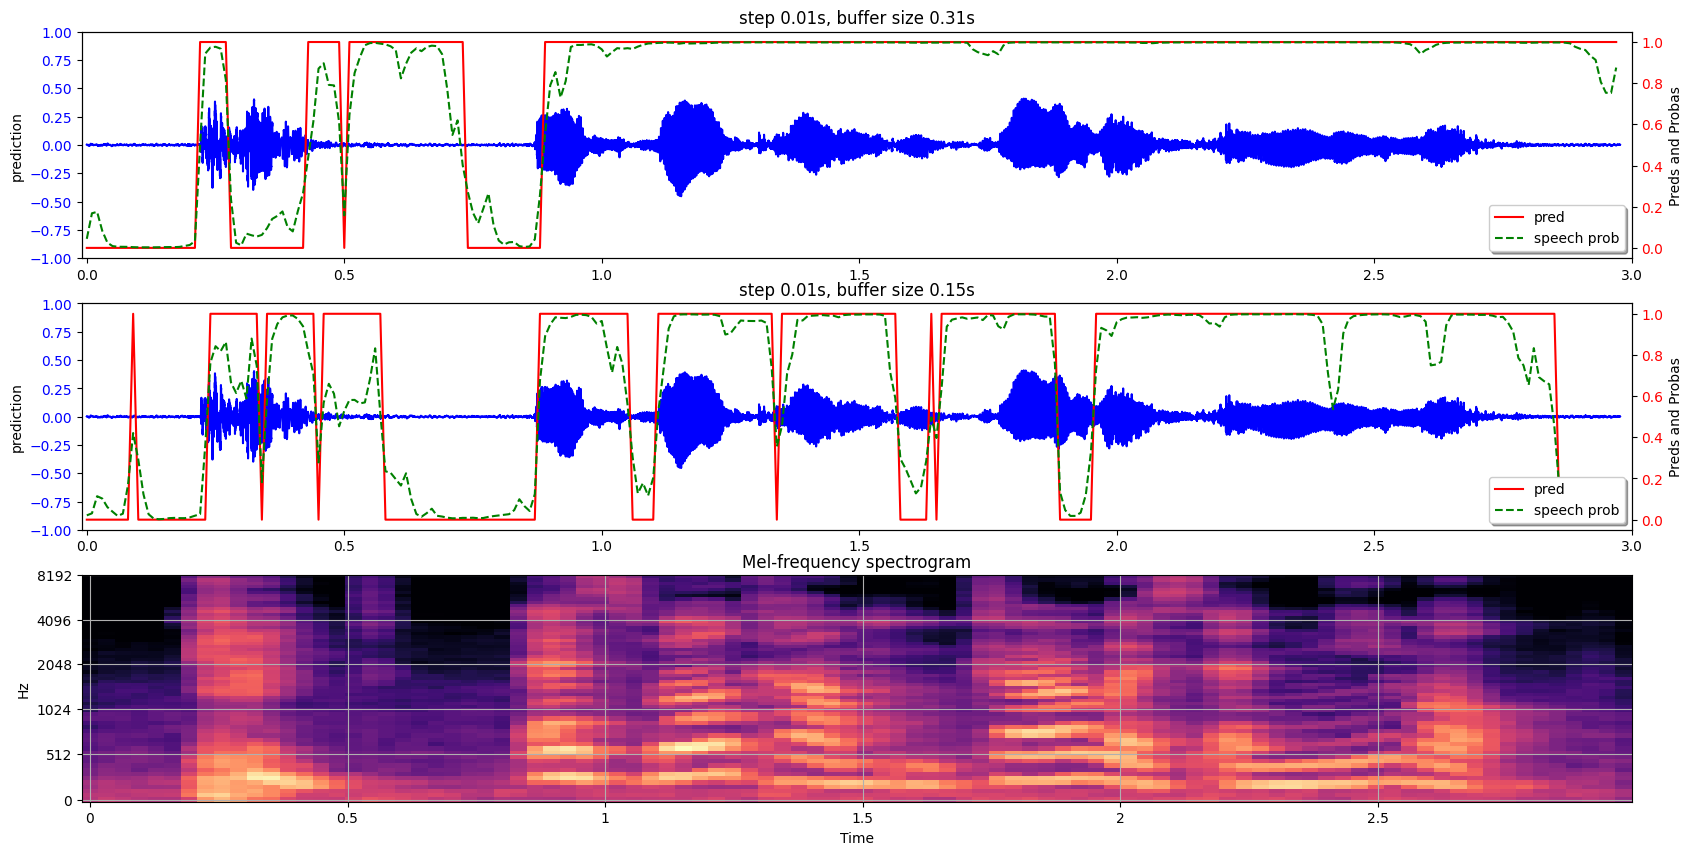

In [20]:
import librosa.display
plt.figure(figsize=[20,10])

num = len(results)
for i in range(num):
    len_pred = len(results[i][2]) 
    FRAME_LEN = results[i][0]
    ax1 = plt.subplot(num+1,1,i+1)

    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'b')
    ax1.set_xlim([-0.01, int(dur)+1]) 
    ax1.tick_params(axis='y', labelcolor= 'b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1,  1])

    proba_s = results[i][4]
    pred = [1 if p > threshold else 0 for p in proba_s]
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(pred)  , 'r', label='pred')
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(proba_s) ,  'g--', label='speech prob')
    ax2.tick_params(axis='y', labelcolor='r')
    legend = ax2.legend(loc='lower right', shadow=True)
    ax1.set_ylabel('prediction')

    ax2.set_title(f'step {results[i][0]}s, buffer size {results[i][1]}s')
    ax2.set_ylabel('Preds and Probas')
    
    
ax = plt.subplot(num+1,1,num+1)
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
ax.set_title('Mel-frequency spectrogram')
ax.grid()
plt.show()

In [21]:
STEP = 0.04
WINDOW_SIZE = 0.31
CHANNELS = 1 
RATE = 16000
FRAME_LEN = STEP
THRESHOLD = 0.95

CHUNK_SIZE = int(STEP * RATE)
vad = FrameVAD(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor,
                   'JasperEncoder': cfg.encoder,
                   'labels': cfg.labels
               },
               threshold=THRESHOLD,
               frame_len=FRAME_LEN, frame_overlap=(WINDOW_SIZE - FRAME_LEN) / 2, 
               offset=0)

In [22]:
import logging
import sys

# Cấu hình logging cơ bản
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout) # Đảm bảo log ra console ngay lập tức
    ]
)
logger = logging.getLogger("VAD_App")

In [23]:
import time
import numpy as np
import pyaudio as pa

# Reset VAD (giả sử đối tượng vad đã tồn tại)
vad.reset()

import queue
import threading

#
# asr_queue = queue.Queue()

# # 2. Hàm Worker chạy ở luồng riêng
# def asr_worker():
#     while True:
#         # Lấy dữ liệu từ queue (sẽ đợi cho đến khi có dữ liệu)
#         audio_data = asr_queue.get()
#         if audio_data is None: break # Lệnh dừng
        
#         logger.info("ASR đang xử lý...")
#         # result = asr_model.transcribe(audio_data)
#         # logger.info(f"Kết quả ASR: {result}")
        
#         asr_queue.task_done()

# worker_thread = threading.Thread(target=asr_worker, daemon=True)
# worker_thread.start()

p = pa.PyAudio()
logger.info('Searching for audio input devices...')

input_devices = []
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev.get('maxInputChannels'):
        input_devices.append(i)
        # Thay print bằng logger.info
        logger.info(f"ID {i}: {dev.get('name')}")

if len(input_devices):
    dev_idx = -2
    while dev_idx not in input_devices:
        try:
            val = input('Please type input device ID: ')
            dev_idx = int(val)
        except ValueError:
            logger.error("Invalid input. Please enter a number.")

    empty_counter = 0

    def callback(in_data, frame_count, time_info, status):
        global empty_counter

        signal = np.frombuffer(in_data, dtype=np.int16)
        text = vad.transcribe(signal)
        
        if len(text):
            if text[0] == 1: 
                logger.info(f"Result: {text}")
                logger.info(f'Offset: {vad.offset}')
            empty_counter = vad.offset
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                logger.debug("Silence detected.") 
                
        return (in_data, pa.paContinue)

    try:
        stream = p.open(format=pa.paInt16,
                        channels=CHANNELS,
                        rate=SAMPLE_RATE,
                        input=True,
                        input_device_index=dev_idx,
                        stream_callback=callback,
                        frames_per_buffer=CHUNK_SIZE)

        logger.info('Microphone is now Listening... (Press Ctrl+C to stop)')
        stream.start_stream()
        
        while stream.is_active():
            time.sleep(0.1)
            
    except KeyboardInterrupt:
        logger.warning("Interrupted by user.")
    finally:        
        if 'stream' in locals():
            stream.stop_stream()
            stream.close()
        p.terminate()
        logger.info("PyAudio stopped and resources cleaned up.")
    
else:
    logger.critical('No audio input device found. Check WSLg/USBIPD connection.')

2026-01-29 16:20:02,245 [INFO] Searching for audio input devices...
2026-01-29 16:20:02,246 [INFO] ID 0: pulse
2026-01-29 16:20:02,247 [INFO] ID 1: default


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No

Please type input device ID:  0


2026-01-29 16:20:08,251 [INFO] Microphone is now Listening... (Press Ctrl+C to stop)
2026-01-29 16:20:09,084 [INFO] Result: [1, 'speech', 0.01437313947826624, 0.9856268763542175, '[-2.1139705  2.1139464]']
2026-01-29 16:20:09,085 [INFO] Offset: 0
2026-01-29 16:20:09,124 [INFO] Result: [1, 'speech', 0.002721962286159396, 0.9972780346870422, '[-2.9518478  2.9518287]']
2026-01-29 16:20:09,126 [INFO] Offset: 0
2026-01-29 16:20:11,700 [INFO] Result: [1, 'speech', 0.006870772689580917, 0.9931291937828064, '[-2.486803   2.4867811]']
2026-01-29 16:20:11,701 [INFO] Offset: 0
2026-01-29 16:20:11,740 [INFO] Result: [1, 'speech', 0.00937331560999155, 0.9906266927719116, '[-2.3302467  2.330224 ]']
2026-01-29 16:20:11,741 [INFO] Offset: 0
2026-01-29 16:20:11,783 [INFO] Result: [1, 'speech', 0.004287316929548979, 0.9957127571105957, '[-2.7239094  2.7238886]']
2026-01-29 16:20:11,784 [INFO] Offset: 0
2026-01-29 16:20:11,824 [INFO] Result: [1, 'speech', 0.0020295099820941687, 0.9979705214500427, '[-3.0

In [24]:
SAMPLE_RATE

16000